In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
plt.style.use('ggplot')

In [2]:
data_path = "./data/eth.csv"
block_data = pd.read_csv(data_path)

In [3]:
time_per_block = 20                       # we assume a block is created every 20s
n_sec = 3600*24                           # seconds per day
block_per_day = int(n_sec/time_per_block) # approximate number of block per day
print("roughly : " ,block_per_day," blocks are created per day")

roughly :  4320  blocks are created per day


In [4]:
contract = {
    "M" : 60*block_per_day,               # 60 day to maturity
    "f" : 10*block_per_day,               # client pay every 10 days
    "x" : 4200000 ,                       # amout of client's payements (Gwei)
    "r" : 30000000,                       # initial reseve locked by the provider (Gwei)
    "max_operations" : {"transfer" : 20}, # client can do 20 transfer every "f" days
    "alpha" : 1
}

In [5]:
start_block = 4000000 # hypothetical current block
end_block   = start_block+contract["M"]

In [6]:
block_data = block_data[(block_data.id>start_block) & (block_data.id < end_block)]

In [23]:
def eth_to_Gwei(eth):
    return 1000000000*eth
def Gwei_to_eth(Gwei):
    return Gwei/1000000000
def gas_refund_return(low,high):
    print(low,high)
    """takes price in ETH, outpu return in Gwei"""
    return eth_to_Gwei(-20000*low+(15000-5000)*high)

n_gas = 21000 # gas needed for simple transfer

def simulate(include_outlier = True,n_hedging_comp=0):
    mean_price = block_data.gas_avg_price.mean()
    
    # select a random outlier
    outlier_price = block_data[block_data.gas_avg_price>10*mean_price].sample(1,random_state=32).gas_avg_price.values[0]
    outlier_price = eth_to_Gwei(outlier_price)
    
    transfers_gas_price = [] # gas price of the transfers performed by the client
    # we sample contract["max_operations"]["transfer"] gas price every "f" days
    for i in range(0,len(block_data),contract["f"]):
        current_prices = block_data[i:i+contract["f"]].gas_avg_price # gas prices in the current "f" days window
        selected_prices = current_prices.sample(contract["max_operations"]["transfer"],random_state=12).values
        transfers_gas_price+=list(selected_prices)
        
    # convert to Gwei
    transfers_gas_price = np.array([eth_to_Gwei(x) for x in transfers_gas_price])
    if include_outlier:
        transfers_gas_price[random.randint(1,len(transfers_gas_price))] =  outlier_price# replace one random tansfer by the outlier 
    
    plt.plot(transfers_gas_price)
    plt.title("Gas fees of the client's transfers")
    plt.xlabel("time")
    plt.ylabel("Gwei")
    plt.show()
    
    #########################################################
    ################## Compute the returns ##################
    #########################################################
    # gas used by the user (Gwei)
    used = transfers_gas_price.sum()*n_gas
    # amount paid by the client to the provider (Gwei)
    tot_client_payement = contract["x"]*(contract["M"]/contract["f"])
    # compute the return of one hedging component, the hedgin compoentn is only used when there is an outlier in the prices (Gwei)
    if include_outlier:
        hedging_component_return = gas_refund_return(low=block_data.iloc[0].gas_avg_price,high=Gwei_to_eth(outlier_price))
    else :
        hedging_component_return = gas_refund_return(low=block_data.iloc[0].gas_avg_price,high=0)
    # return or loss of the provider (Gwei)
    provider_return = tot_client_payement-used +n_hedging_comp*hedging_component_return
    ###################################################
    ################## Print results ##################
    ###################################################    
    prec = 5
    print("================== Client side ==================")
    print("The client used  : ",round(Gwei_to_eth(used),prec),f" ETH of gas )")  
    print("The client payed : ",round(Gwei_to_eth(tot_client_payement),prec)," ETH in total")
    print("The client saved : ",round(Gwei_to_eth(used)-Gwei_to_eth(tot_client_payement),prec) ,"ETH using the system")
    print("================= Provider side =================")
    print("Hedging component return: ",round(Gwei_to_eth(hedging_component_return),prec)," ETH")
    print("Number of hedging component : ",n_hedging_comp)
    print("The provider's return is : ",round(Gwei_to_eth(provider_return),prec)," ETH")

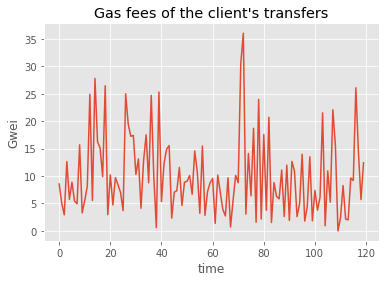

6.401934673e-09 6.445661197e-09
================== Client side ==================
The client used  :  0.02509  ETH of gas )
The client payed :  0.0252  ETH in total
The client saved :  -0.00011 ETH using the system
================= Provider side =================
Hedging component return:  -6e-05  ETH
Number of hedging component :  10
The provider's return is :  -0.00053  ETH


In [24]:
simulate(include_outlier=False,n_hedging_comp=10)

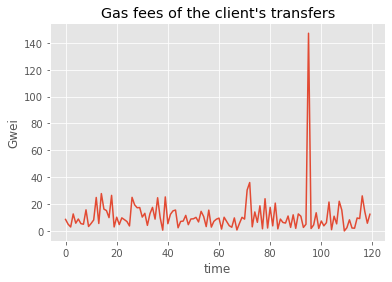

6.401934673e-09 1.47145531381e-07
================== Client side ==================
The client used  :  0.02789  ETH of gas )
The client payed :  0.0252  ETH in total
The client saved :  0.00269 ETH using the system
================= Provider side =================
Hedging component return:  0.00134  ETH
Number of hedging component :  10
The provider's return is :  0.01074  ETH


In [19]:
simulate(include_outlier=True,n_hedging_comp=10)

In [12]:
transfers_gas_price  =[]
for i in range(0,len(block_data),contract["f"]):
        current_prices = block_data[i:i+contract["f"]].gas_avg_price # gas prices in the current "f" days window
        selected_prices = current_prices.sample(contract["max_operations"]["transfer"],random_state=32).values
        transfers_gas_price+=list(selected_prices)